# Blocked cross validation, (2 folds)

### Read phenological weights matrix

In [2]:
# Read weights matrix
import csv

# Initialize an empty list to store the rows of the CSV file
W_matrix = []
# Open the CSV file for reading
with open('/Users/andres/Documents/strawberry-forecasting/scripts/weights.csv', newline='') as csvfile:
    # Create a CSV reader object
    reader = csv.reader(csvfile)
    # Iterate over each row in the CSV file
    for row in reader:
        # Append the row to the matrix list
        W_matrix.append(row)

### Load data

In [55]:
import pandas as pd
import numpy as np

month = ['06', '06', '07', '07', '07', '07', '07', '07', '08', '08', '08', '08', '08', '09', '09', '09']
day = ['17', '28', '05', '08', '15', '19', '26', '29', '02', '05', '09', '12', '29', '01', '20', '22']
year = '2022'
existing_csv_file = []
for i in range(len(month)):
    join_date = '-'.join([month[i], day[i], year])
    #existing_csv_file.append('/Users/andres/Documents/yield_data/adjusted_yield/' + join_date + '_x1.csv')
    existing_csv_file.append('/Users/andres/Documents/strawberry-forecasting/data/discrete_yield/' + join_date + '_x4bs.csv')

df_0617 = pd.read_csv(existing_csv_file[0])
df_0628 = pd.read_csv(existing_csv_file[1])
df_0705 = pd.read_csv(existing_csv_file[2])
df_0708 = pd.read_csv(existing_csv_file[3])
df_0715 = pd.read_csv(existing_csv_file[4])
df_0719 = pd.read_csv(existing_csv_file[5])
df_0726 = pd.read_csv(existing_csv_file[6])
df_0729 = pd.read_csv(existing_csv_file[7])
df_0802 = pd.read_csv(existing_csv_file[8])
df_0805 = pd.read_csv(existing_csv_file[9])
df_0809 = pd.read_csv(existing_csv_file[10])
df_0812 = pd.read_csv(existing_csv_file[11])
df_0829 = pd.read_csv(existing_csv_file[12])
df_0901 = pd.read_csv(existing_csv_file[13])
df_0920 = pd.read_csv(existing_csv_file[14])
df_0922 = pd.read_csv(existing_csv_file[15])

df_list = [df_0617, df_0628, df_0705, df_0708, df_0715, df_0719, df_0726, df_0729, df_0802, df_0805, df_0809, df_0812,
           df_0829, df_0901, df_0920, df_0922] 

flower_counts = []
green_counts = []
sw_counts = []
lw_counts = []
pink_counts = []
red_counts = []
time_spacing = [11, 7, 3, 7, 4, 7, 3, 4, 3, 4, 3, 17, 2, 19, 2, -1]

df_count = 0
for df in df_list:
    try:
        flower_counts.append(df['flower'])
        green_counts.append(df['green'])
        sw_counts.append(df['sw'])
        lw_counts.append(df['lw'])
        pink_counts.append(df['pink'])
        if df_count > 0:
            red_counts.append(df['red'])
    except KeyError:
        print(f"DataFrame: {df_list.index(df) + 1}, Column or Row not found.")
    df_count += 1
new_row = [-1] * len(flower_counts[0])  # Create a new row with -1 values for each column 
red_counts.append(new_row) # Add -1 value to red count in the last date as it is not known 

counts_list = [flower_counts, green_counts, sw_counts, lw_counts, pink_counts, red_counts] # shape = (features,dates,locations)

num_rows = len(counts_list[0][0])
dataset_list = [[] for _ in range(num_rows)] # shape = (locations,(features*dates))

for loc_idx in range(len(counts_list[0][0])):
    for _stage in range(len(counts_list)):
        for _date in range(len(counts_list[0])):
            dataset_list[loc_idx].append(counts_list[_stage][_date][loc_idx])
increment = int(len(dataset_list[0])/6)

### Training on blocks for cross-validation

In [318]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint
import copy

sequence_length = 3  
n_seqs = 5
ex_dates = 1
const = 1
k_folds = 2

R2_list = []
MSE_list = []
_X_per_t = [[[] for _ in range(n_seqs)] for _ in range(k_folds)]
_y_per_t = [[[] for _ in range(n_seqs)] for _ in range(k_folds)]
_y_train_ext = []
_X_train_ext = []
_fold_ranges = []
for k_fold in range(k_folds):
    _fold_range = []
    for i in range(k_fold*(int((len(counts_list[0])-ex_dates)/k_folds)), (const+k_fold*(int((len(counts_list[0])-ex_dates)/k_folds))+n_seqs)):
        _fold_range.append(i)
    _fold_ranges.append(_fold_range)
for k_fold in range(k_folds):
    X_train = []
    y_train = []
    X_test = []
    y_test = []
    #print('New fold:', k_fold)
    n_time_spacing = copy.copy(time_spacing)
    for row_idx in range(len(counts_list[0][0])):
        n_flower_counts = dataset_list[row_idx][0:increment]
        n_green_counts = dataset_list[row_idx][increment:increment*2]
        n_sw_counts = dataset_list[row_idx][increment*2:increment*3]
        n_lw_counts = dataset_list[row_idx][increment*3:increment*4]
        n_pink_counts = dataset_list[row_idx][increment*4:increment*5]
        n_red_counts = dataset_list[row_idx][increment*5:increment*6]
        # Define training set
        _train_limits = []
        _test_limits = []
        for set in range(k_folds):
            if set != k_fold:
                _train_limits.append(_fold_ranges[set])
            else:
                _test_limits.append(_fold_ranges[set])
        # Define train set
        X, y = [], []
        #print('getting train sequences')
        for i in list(range(_train_limits[0][0],_train_limits[0][n_seqs])):
            gaps_vector = n_time_spacing[i:i+sequence_length]
            kf_flower = n_flower_counts[i:i+sequence_length]
            kf_green = n_green_counts[i:i+sequence_length]
            kf_sw = n_sw_counts[i:i+sequence_length]
            kf_lw = n_lw_counts[i:i+sequence_length]
            kf_pink = n_pink_counts[i:i+sequence_length]
            kf_time = n_time_spacing[i:i+sequence_length]
            kf_red = n_red_counts[i+sequence_length-1]
            #
            sum_gaps = []
            gap_sum = 0
            for gap_idx in range(len(gaps_vector) - 1,-1,-1):
                gap_sum += gaps_vector[gap_idx]
                sum_gaps.append(gap_sum)
            sum_gaps.reverse()
            _green_w = []
            _sw_w = []
            _lw_w = []
            _pink_w = []
            _flower_w = []
            for date in sum_gaps:
                _flower_w.append(float(W_matrix[date][0]))
                _green_w.append(float(W_matrix[date][1]))
                _sw_w.append(float(W_matrix[date][2]))
                _lw_w.append(float(W_matrix[date][3]))
                _pink_w.append(float(W_matrix[date][4]))
            input_sequence = [
                np.multiply(kf_flower,_flower_w),
                np.multiply(kf_green,_green_w),
                np.multiply(kf_sw,_sw_w),
                np.multiply(kf_lw,_lw_w),
                np.multiply(kf_pink,_pink_w),
                #kf_green,
                #kf_sw,
                #kf_lw,
                #kf_pink,
                np.array(sum_gaps),
                #kf_time
            ]
            X.append(np.transpose(input_sequence))
            y.append(kf_red)
        X_train.append(X)
        y_train.append(y)
        # Define test set
        _X, _y = [], []
        #print('getting test sequences')
        for i in range(_test_limits[0][0],_test_limits[0][n_seqs]):
            gaps_vector = n_time_spacing[i:i+sequence_length]
            kf_flower = n_flower_counts[i:i+sequence_length]
            kf_green = n_green_counts[i:i+sequence_length]
            kf_sw = n_sw_counts[i:i+sequence_length]
            kf_lw = n_lw_counts[i:i+sequence_length]
            kf_pink = n_pink_counts[i:i+sequence_length]
            kf_time = n_time_spacing[i:i+sequence_length]
            kf_red = n_red_counts[i+sequence_length-1]
            #
            sum_gaps = []
            gap_sum = 0
            for gap_idx in range(len(gaps_vector) - 1,-1,-1):
                gap_sum += gaps_vector[gap_idx]
                sum_gaps.append(gap_sum)
            sum_gaps.reverse()
            _flower_w = []
            _green_w = []
            _sw_w = []
            _lw_w = []
            _pink_w = []
            for date in sum_gaps:
                _flower_w.append(float(W_matrix[date][0]))
                _green_w.append(float(W_matrix[date][1]))
                _sw_w.append(float(W_matrix[date][2]))
                _lw_w.append(float(W_matrix[date][3]))
                _pink_w.append(float(W_matrix[date][4]))
            input_sequence = [
                np.multiply(kf_flower,_flower_w),
                np.multiply(kf_green, _green_w),
                np.multiply(kf_sw,_sw_w),
                np.multiply(kf_lw,_lw_w),
                np.multiply(kf_pink,_pink_w),
                #kf_green,
                #kf_sw,
                #kf_lw,
                #kf_pink,
                np.array(sum_gaps),
                #kf_time
            ]
            _X.append(np.transpose(input_sequence))
            _y.append(kf_red)
        X_test.append(_X)
        y_test.append(_y)
    X_train_extended = np.concatenate(X_train, axis=0)
    y_train_extended = np.concatenate(y_train, axis=0)
    X_test_extended = np.concatenate(X_test, axis=0)
    y_test_extended = np.concatenate(y_test, axis=0)

    n_features = len(X_train[0][0][0])
    #Create the LSTM model
    model = Sequential()
    model.add(LSTM(80, activation='linear', return_sequences=True, input_shape=(sequence_length,n_features)))  # Adjust input shape
    model.add(Dropout(0.1))
    #model.add(LSTM(80, activation='linear', return_sequences=True))
    #model.add(Dropout(0.1))
    model.add(LSTM(40, activation='relu', return_sequences=True))
    model.add(Dropout(0.1))
    model.add(LSTM(40, activation='relu', return_sequences=True))
    model.add(Dropout(0.1))
    model.add(LSTM(20, activation='relu'))
    model.add(Dense(1))#, activation='linear'))
    # Compile the model
    model.compile(optimizer='Adagrad', loss='huber_loss')
    #model.summary()
    # Save the model architecture and weights
    model.save('date_best_model_'+str(k_fold)+'.h5')
    # Define the ModelCheckpoint callback
    checkpoint = ModelCheckpoint('date_best_model_'+str(k_fold)+'.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
    # Add validation split and ModelCheckpoint to the fit function
    history = model.fit(X_train_extended, y_train_extended, shuffle=False, epochs=100, batch_size=32, validation_split=0.2, callbacks=[checkpoint])
    # Load the best model
    #best_model = load_model('date_best_model_'+str(k_fold)+'.h5')
    # Save y_test and X_test for every test date in both folds
    for loc_x,loc_y in zip(X_test,y_test):
        for idx,input_X in enumerate(loc_x):
            _y_per_t[k_fold][idx].append(loc_y[idx])
            _X_per_t[k_fold][idx].append(input_X)
    # Save train data for every fold
    _y_train_ext.append(y_train_extended)
    _X_train_ext.append(X_train_extended)

Epoch 1/100


/opt/anaconda3/envs/forecast/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


 1/10 [==>...........................] - ETA: 17s - loss: 26.8185
Epoch 1: val_loss improved from inf to 32.23804, saving model to date_best_model_0.h5
10/10 [==============================] - 2s 36ms/step - loss: 37.4878 - val_loss: 32.2380
Epoch 2/100
 1/10 [==>...........................] - ETA: 0s - loss: 26.8049
Epoch 2: val_loss improved from 32.23804 to 32.22309, saving model to date_best_model_0.h5
10/10 [==============================] - 0s 8ms/step - loss: 37.4685 - val_loss: 32.2231
Epoch 3/100
 1/10 [==>...........................] - ETA: 0s - loss: 26.7965
Epoch 3: val_loss improved from 32.22309 to 32.20800, saving model to date_best_model_0.h5
10/10 [==============================] - 0s 8ms/step - loss: 37.4551 - val_loss: 32.2080
Epoch 4/100
 1/10 [==>...........................] - ETA: 0s - loss: 26.7820
Epoch 4: val_loss improved from 32.20800 to 32.19135, saving model to date_best_model_0.h5
10/10 [==============================] - 0s 7ms/step - loss: 37.4384 - val_l

## Plots from training

### Scatter plots and box plots for R2, MSE (Fold 0)

3/3 [==============================] - 0s 2ms/step - loss: 4.2439


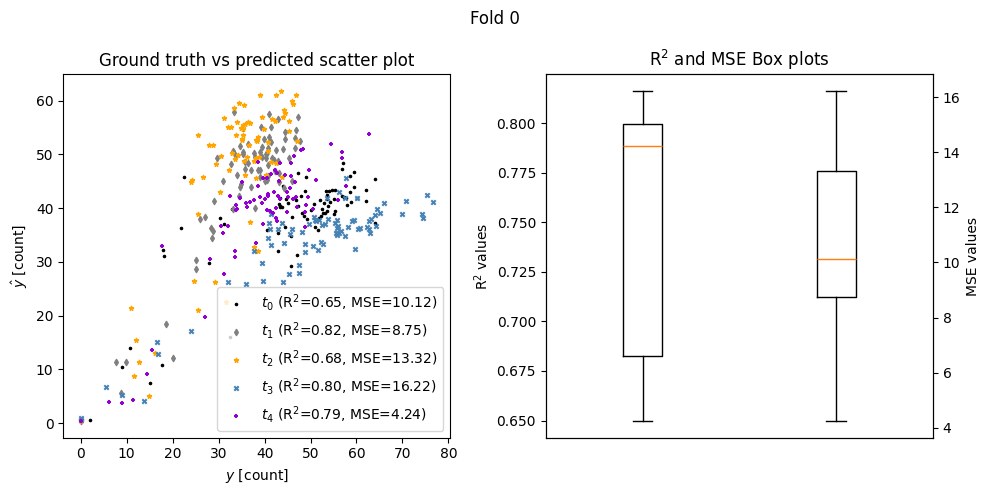

In [319]:
import matplotlib.pyplot as plt
from scipy.stats import linregress

_r2 = []
_mse = []
_y_hat_0 = []
n = 0
fig,(p1,p2) = plt.subplots(1,2,figsize=(10,5))
scatter_marker = ['.','d','*','x','+']
scatter_color = ['black','gray','orange','steelblue','darkviolet']
for k_fold in range(0,1):
    best_model = load_model('date_best_model_'+str(k_fold)+'.h5')
    for X_t,y_t in zip(_X_per_t[k_fold],_y_per_t[k_fold]):
        y_hat = best_model.predict(np.array(X_t))
        y_target = y_t
        slope, intercept, r_value, p_value, std_err = linregress(y_target, np.ravel(y_hat))
        r_squared = r_value ** 2
        _r2.append(r_squared)
        mse = best_model.evaluate(np.array(X_t), np.array(y_target))
        _mse.append(mse)
        _y_hat_0.append(y_hat)
        p1.scatter(y_target, y_hat,s=10,alpha=1, color=scatter_color[n],marker=scatter_marker[n],label=f'$t_{n}$ (R$^{2}$={_r2[n]:.2f}, MSE={mse:.2f})')
        n+=1
p1.set_xlabel('$y$ [count]')
p1.set_ylabel('$\hat{y}$ [count]')
p1.set_title('Ground truth vs predicted scatter plot')
p1.legend()
#
p2.boxplot(_r2, widths=0.2,positions=[1])  # Box plot for R2 values
p2.set_ylabel('R$^2$ values')
p2.set_xticks([])
#
p2_mse = p2.twinx()  # Create another twin y-axis for MSE values
p2_mse.boxplot(_mse, widths=0.2,positions=[2])
p2_mse.set_ylabel('MSE values')
p2_mse.set_xticks([])
p2.set_title('R$^2$ and MSE Box plots')
#
fig.suptitle('Fold '+str(k_fold))
plt.tight_layout()
plt.savefig('/Users/andres/Documents/strawberry-forecasting/images/metrics_35_0f_xT.pdf', dpi=300)
plt.show()

In [110]:
np.ravel(y_hat).shape

(79,)

### Scatter plots and box plots for R2, MSE (Fold 1)

3/3 [==============================] - 0s 2ms/step - loss: 5.6364


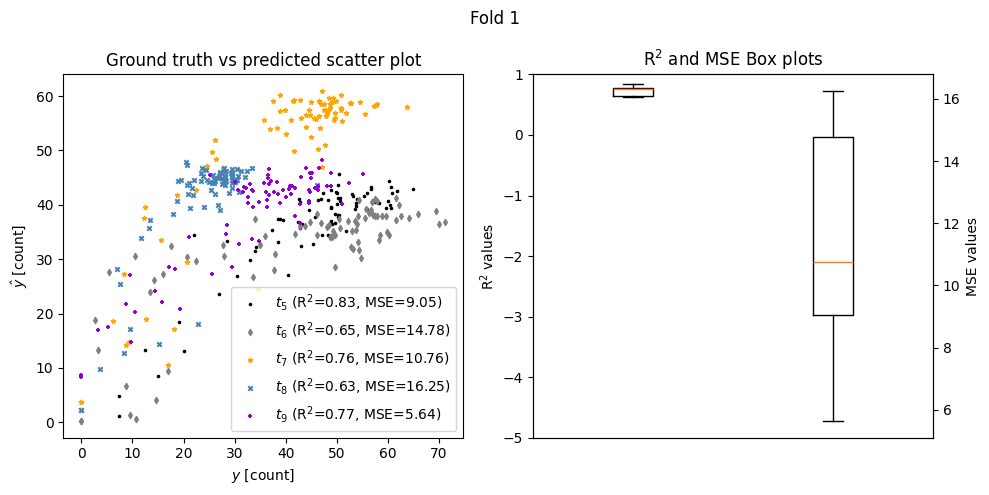

In [320]:
#y_increment = int(len(_y_w)/(n_seqs*2))
_r2 = []
_mse = []
_y_hat_1 = []
n = n_seqs
fig,(p1,p2) = plt.subplots(1,2,figsize=(10,5))
scatter_marker = ['.','d','*','x','+']
scatter_color = ['black','gray','orange','steelblue','darkviolet']
for k_fold in range(1,2):
    best_model = load_model('date_best_model_'+str(k_fold)+'.h5')
    for X_t,y_t in zip(_X_per_t[k_fold],_y_per_t[k_fold]):
        y_hat = best_model.predict(np.array(X_t))
        #y_hat = _y_w[n*y_increment:y_increment*(n+1)]
        y_target = y_t
        slope, intercept, r_value, p_value, std_err = linregress(y_target, np.ravel(y_hat))
        r_squared = r_value ** 2
        _r2.append(r_squared)
        mse = best_model.evaluate(np.array(X_t), np.array(y_target))
        #mse = mean_squared_error(y_target, y_hat)
        _mse.append(mse)
        _y_hat_1.append(y_hat)
        p1.scatter(y_target, y_hat,s=10,alpha=1, color=scatter_color[n-n_seqs],marker=scatter_marker[n-n_seqs],label=f'$t_{n}$ (R$^{2}$={_r2[n-n_seqs]:.2f}, MSE={mse:.2f})')
        n+=1
p1.set_xlabel('$y$ [count]')
p1.set_ylabel('$\hat{y}$ [count]')
p1.set_title('Ground truth vs predicted scatter plot')
p1.legend()
#
p2.boxplot(_r2, widths=0.2,positions=[1])  # Box plot for R2 values
p2.set_ylabel('R$^2$ values')
p2.set_ylim(-5, 1)
p2.set_xticks([])
#
p2_mse = p2.twinx()  # Create another twin y-axis for MSE values
p2_mse.boxplot(_mse, widths=0.2,positions=[2])
p2_mse.set_ylabel('MSE values')
p2_mse.set_xticks([])
p2.set_title('R$^2$ and MSE Box plots')
#
fig.suptitle('Fold '+str(k_fold))
plt.tight_layout()
plt.savefig('/Users/andres/Documents/strawberry-forecasting/images/metrics_35_1f_xT.pdf', dpi=300)
plt.show()

### R2 and MSE plots for average yield (fold 0)

3/3 [==============================] - 0s 1ms/step
-0.6061375546775749 60.21753259692463


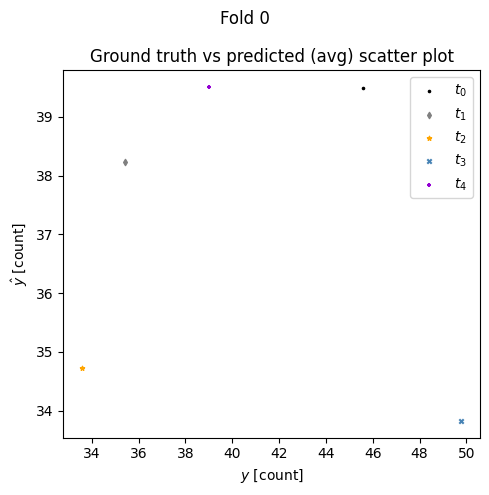

In [103]:
from sklearn.metrics import mean_squared_error

n = 0
_total_red_pred = []
_total_red_true = []

fig, p1 = plt.subplots(1,1,figsize=(5,5))
scatter_marker = ['.','d','*','x','+']
scatter_color = ['black','gray','orange','steelblue','darkviolet']

for k_fold in range(0,1):
    best_model = load_model('date_best_model_'+str(k_fold)+'.h5')
    for X_t,y_t in zip(_X_per_t[k_fold],_y_per_t[k_fold]):
        t_y_pred = 0.0
        t_y_true = 0.0
        y_hat = best_model.predict(np.array(X_t))
        #y_hat = _y_w[n*y_increment:y_increment*(n+1)]
        y_target = y_t
        t_y_pred = np.mean(y_hat)
        t_y_true = np.mean(y_target)
        _total_red_pred.append(t_y_pred)
        _total_red_true.append(t_y_true)
        p1.scatter(t_y_true, t_y_pred,s=10,alpha=1, color=scatter_color[n],marker=scatter_marker[n],label=f'$t_{n}$')
        n+=1
p1.set_xlabel('$y$ [count]')
p1.set_ylabel('$\hat{y}$ [count]')
p1.set_title('Ground truth vs predicted (avg) scatter plot')
p1.legend()

R2 = r2_score(_total_red_true, _total_red_pred)
MSE = mean_squared_error(_total_red_true, _total_red_pred)

#p1.text(42,32.5,f'R$^2$ = {R2:.2f}, MSE = {MSE:.2f}')
#p1.text(42,27.8,f'R$^2$ = {R2:.2f}, MSE = {MSE:.2f}')
print(R2,MSE)
fig.suptitle('Fold '+str(k_fold))
plt.tight_layout()
#plt.savefig('/Users/andres/Documents/python_forecast/avg_metrics_35_0f_both.pdf', dpi=300)
plt.show()


### R2 and MSE plots for average yield (fold 1)

3/3 [==============================] - 0s 1ms/step
0.4690427575943321 28.872299002700505


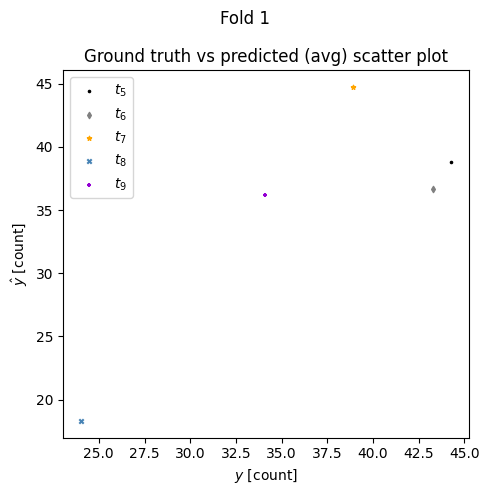

In [104]:
n=n_seqs
_total_red_pred = []
_total_red_true = []

fig, p1 = plt.subplots(1,1,figsize=(5,5))
scatter_marker = ['.','d','*','x','+']
scatter_color = ['black','gray','orange','steelblue','darkviolet']

for k_fold in range(1,2):
    best_model = load_model('date_best_model_'+str(k_fold)+'.h5')
    for X_t,y_t in zip(_X_per_t[k_fold],_y_per_t[k_fold]):
        t_y_pred = 0.0
        t_y_true = 0.0
        y_hat = best_model.predict(np.array(X_t))
        #y_hat = _y_w[n*y_increment:y_increment*(n+1)]
        y_target = y_t
        t_y_pred = np.mean(y_hat)
        t_y_true = np.mean(y_target)
        _total_red_pred.append(t_y_pred)
        _total_red_true.append(t_y_true)
        p1.scatter(t_y_true, t_y_pred,s=10,alpha=1, color=scatter_color[n-n_seqs],marker=scatter_marker[n-n_seqs],label=f'$t_{n}$')
        n+=1
p1.set_xlabel('$y$ [count]')
p1.set_ylabel('$\hat{y}$ [count]')
p1.set_title('Ground truth vs predicted (avg) scatter plot')
p1.legend()

R2 = r2_score(_total_red_true, _total_red_pred)
MSE = mean_squared_error(_total_red_true, _total_red_pred)

#p1.text(35,35.5,f'R$^2$ = {R2:.2f}, MSE = {MSE:.2f}')
#p1.text(35,40.0,f'R$^2$ = {R2:.2f}, MSE = {MSE:.2f}')
print(R2,MSE)
fig.suptitle('Fold '+str(k_fold))
plt.tight_layout()
#plt.savefig('/Users/andres/Documents/python_forecast/avg_metrics_35_1f_both.pdf', dpi=300)
plt.show()
